In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

ГІПЕРПАРАМЕТРИ

In [ ]:
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 0.001

ЗАВАНТАЖУЄМО ДАТАСЕТ ТА РОЗБИВАЄМО НА НАВЧАЛЬНУ ТА ТЕСТОВІ ДАНІ

In [ ]:
(train_data, val_data, test_data), metadata = tfds.load('emnist', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],with_info=True)
print(metadata.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/697932 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteS8AAH6/emnist-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/116323 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteS8AAH6/emnist-test.tfrecord*...:   0%|     …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=62),
})


ВІЗУАЛІЗУЄМО НАВЧАЛЬНІ ДАНІ

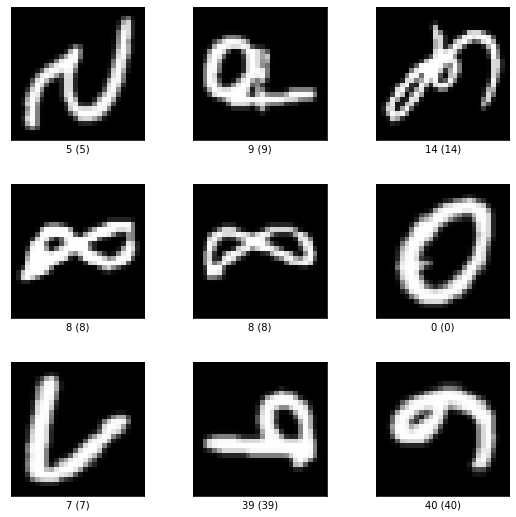

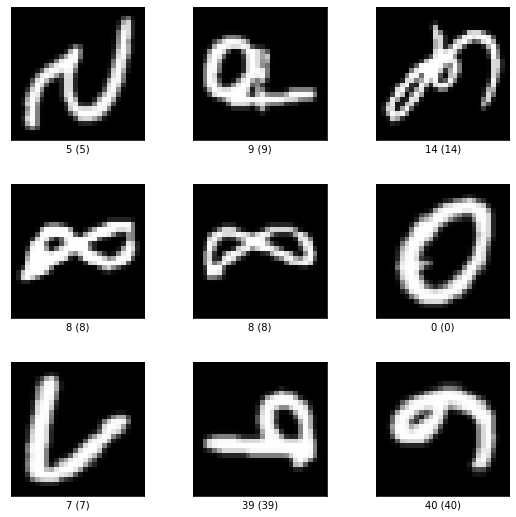

In [ ]:
tfds.visualization.show_examples(train_data, metadata)

НОРМАЛІЗУЄМО

In [ ]:
def preprocess(dataset):
    image = tf.cast(dataset['image'], dtype=tf.float32) / 255.
    label = tf.cast(dataset['label'], dtype=tf.float32)
    return image, label


train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

СТВОРЮЄМО МОДЕЛЬ БАГАТОШАРОВОГО ПЕРСЕПТРОНА

In [ ]:
def simple_mlp_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(28, 28, 1,))
    x = tf.keras.layers.Flatten()(input_)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.models.Model(input_, output_, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = simple_mlp_model(num_classes)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               100480    
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 62)                4030      
                                                                 
Total params: 112,766
Trainable params: 112,766
Non-trainable params: 0
_________________________________________________________________


ТРЕНУЄМО МОДЕЛЬ

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE,
                                                             decay_steps=100000,
                                                             decay_rate=0.96)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/20
1091/1091 [==============================] - 52s 48ms/step - loss: 0.9903 - accuracy: 0.7211 - val_loss: 0.6696 - val_accuracy: 0.7896
Epoch 2/20
1091/1091 [==============================] - 53s 48ms/step - loss: 0.6162 - accuracy: 0.8024 - val_loss: 0.5720 - val_accuracy: 0.8123
Epoch 3/20
1091/1091 [==============================] - 53s 48ms/step - loss: 0.5512 - accuracy: 0.8182 - val_loss: 0.5322 - val_accuracy: 0.8240
Epoch 4/20
1091/1091 [==============================] - 52s 47ms/step - loss: 0.5174 - accuracy: 0.8266 - val_loss: 0.5103 - val_accuracy: 0.8286
Epoch 5/20
1091/1091 [==============================] - 51s 47ms/step - loss: 0.4968 - accuracy: 0.8315 - val_loss: 0.5024 - val_accuracy: 0.8301
Epoch 6/20
1091/1091 [==============================] - 54s 49ms/step - loss: 0.4820 - accuracy: 0.8352 - val_loss: 0.4892 - val_accuracy: 0.8333
Epoch 7/20
1091/1091 [==============================] - 52s 47ms/step - loss: 0.4697 - accuracy: 0.8382 - val_loss: 0.4828 -

РЕЗУЛЬТАТ МОДЕЛІ НА ТЕСТОВИХ ДАНИХ

In [ ]:
metrics = model.evaluate(test_data, batch_size=BATCH_SIZE, verbose=1)
metric_names = ['Test loss', 'Test Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')

137/137 [==============================] - 5s 40ms/step - loss: 0.4666 - accuracy: 0.8384
Test loss : 0.4666183888912201
Test Accuracy : 0.83839350938797


ГРАФІКИ

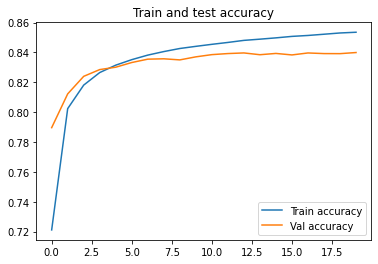

<Figure size 7200x7200 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.title('Train and test accuracy')
plt.legend()
plt.figure(figsize = (100,100))
plt.show()

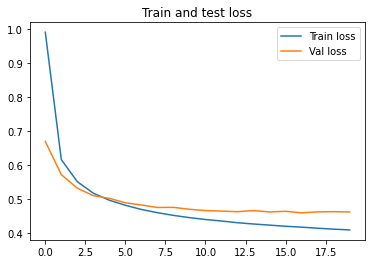

<Figure size 40000x40000 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize = (200,200), dpi=200)
plt.show()